#### Comparing and evaluating clustering algorithms
##### Evaluating clustering with ground truth
- 훈련 데이터에 대한 Target을 알고 있을 때 Clustering Algorithm 평가방법
  - ARI (Adjusted Rand Index)
    - adjusted_rand_score(y, predicted_clusters)
    - 무작위 클러스터링: 0
    - 1에 가까운 값일수록 타깃과 더 유사한 클러스터링 결과
  - NMI (Normalized Mutual Information)
    - normalized_mutual_infro_score(y, predicted_clusters)  
    - 무작위 클러스터링: 0
    - 1에 가까운 값일수록 타깃과 더 유사한 클러스터링 결과    

In [1]:
%matplotlib inline
import sys 
sys.path.append('..')
from preamble import *

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


- ARI (Adjusted Rand Index)

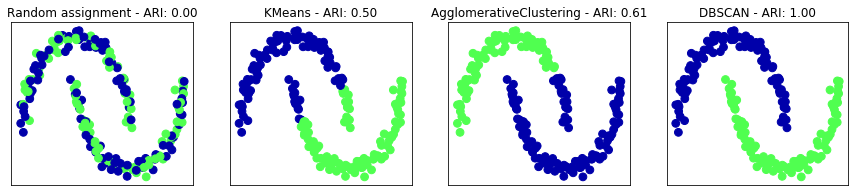

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y, clusters)))

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score

# these two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# accuracy is zero, as none of the labels are the same
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))

# adjusted rand score is 1, as the clustering is exactly the same:
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

# normalized mutual information score is 1, as the clustering is exactly the same:
print("NMI: {:.2f}".format(normalized_mutual_info_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00
NMI: 1.00


##### Evaluating clustering without ground truth
- 수집한 데이터 자체에 Target 값이 없을 때 클러스터링 알고리즘 성능 평가하기
  - Sihouette Coefficient (실루엣 계수)
    - 그다지 추천하지 않음
    - 클러스터의 밀집정도를 계산함 - 밀집정도가 높을 수록 1에 가까운 값을 반환함.
  - Robustness-based Evaluation (견고성 기반 평가)
    - 데이터에 잡음 포인트를 추가하거나 여러가지 매개변수 설정으로 알고리즘을 실행하여도 클러스터 구성이 변하지 않을 때 해당 클러스터 구성 결과에 높은 신뢰도가 있다고 볼 수 있음
    - scikit-learn에서는 지원하지 않음
  - 사람이 직접 확인하는 방법

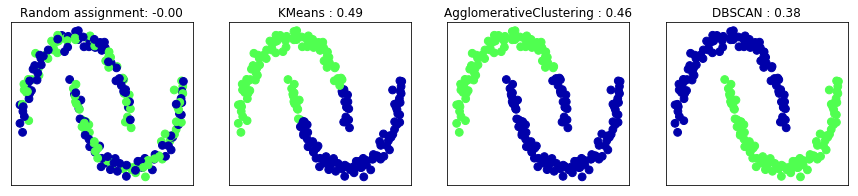

In [5]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))

##### Comparing algorithms on the faces dataset
- LFW 데이터셋에 대한 k-means, DBSCAN, Agglomerative Clustering 적용 결과 비교
- LFW 데이터셋에 대하여 PCA 적용하여 주성분 100개의 얼굴데이터 활용

##### Analyzing the faces dataset with DBSCAN

- eps=0.5, min_samples=5

In [6]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
pca = PCA(n_components=100, whiten=True, random_state=0)
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    print("np.where(people.target == {0}):\n{1}".format(target, np.where(people.target == target)))
    mask[np.where(people.target == target)[0][:50]] = 1
    print()
X_people = people.data[mask]
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)
# apply DBSCAN with default parameters
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

np.where(people.target == 0):
(array([  58,   72,   90,  314,  494,  496,  598,  650,  960, 1078, 1212,
       1243, 1265, 1356, 1497, 1586, 1622, 1793, 1803, 1816, 1881, 1952,
       1962, 2003, 2068, 2179, 2183, 2239, 2373, 2441, 2510, 2535, 2622,
       2649, 2651, 2697, 2819, 2960, 2998], dtype=int64),)

np.where(people.target == 1):
(array([   4,   17,   41,   87,  142,  216,  333,  413,  417,  508,  857,
        876,  940,  944,  949, 1165, 1307, 1505, 1529, 1539, 1729, 1807,
       1837, 1933, 2211, 2243, 2254, 2269, 2285, 2290, 2360, 2387, 2616,
       2636, 2926], dtype=int64),)

np.where(people.target == 2):
(array([  65,  188,  266,  509,  912, 1055, 1102, 1353, 1379, 1468, 1868,
       1924, 2073, 2115, 2180, 2272, 2344, 2412, 2444, 2492, 2531],
      dtype=int64),)

np.where(people.target == 3):
(array([  27,  237,  388,  449,  461,  612,  623,  676,  738,  770, 1106,
       1132, 1187, 1270, 1273, 1280, 1710, 1714, 1752, 1942, 2056, 2074,
       2160, 2176, 2206, 2216, 22

Unique labels: [-1]


- eps=0.5, min_samples=3

In [7]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("고유한 레이블: {}".format(np.unique(labels)))

고유한 레이블: [-1]


- eps=15, min_samples=3

In [8]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("고유한 레이블: {}".format(np.unique(labels)))

고유한 레이블: [-1]


In [9]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("고유한 레이블: {}".format(np.unique(labels)))

고유한 레이블: [-1  0]


- 잡음 포인트와 클러스터로 분류된 포인트의 개수를 카운트
- np.bincount 활용
  - np.bincount는 음수를 허용하지 않기 때문에 1을 더하여 활용 
  - 잡음 포인트: 32개
  - 클러스터로 분류된 포인트: 2031개

In [10]:
# count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# the first number in the result corresponds to noise points
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  32 2031]


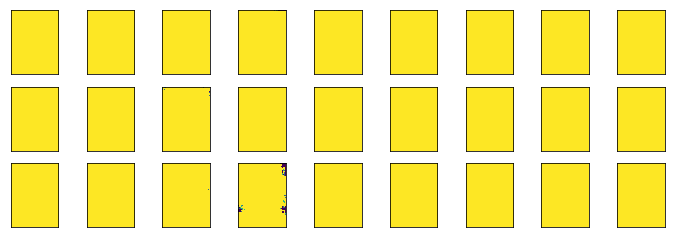

In [11]:
noise = X_people[labels==-1]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

- 잡음으로 분류된 이유 추정
  - 손이 얼굴 앞을 가리고 있는 경우
  - 얼굴 각도가 이상한 경우
  - 얼굴을 너무 가까이서 혹은 너무 멀리서 자른 경우
- Outlier Detection (이상치 검출)

- eps 값을 줄여서 더 많은 클러스터 구성하기

In [12]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("클러스터 수: {}".format(len(np.unique(labels))))
    print("클러스터 크기: {}".format(np.bincount(labels + 1)))


eps=1
클러스터 수: 1
클러스터 크기: [2063]

eps=3
클러스터 수: 1
클러스터 크기: [2063]

eps=5
클러스터 수: 1
클러스터 크기: [2063]

eps=7
클러스터 수: 14
클러스터 크기: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
클러스터 수: 4
클러스터 크기: [1307  750    3    3]

eps=11
클러스터 수: 2
클러스터 크기: [ 413 1650]

eps=13
클러스터 수: 2
클러스터 크기: [ 120 1943]


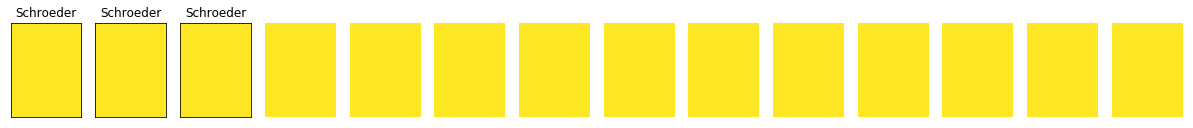

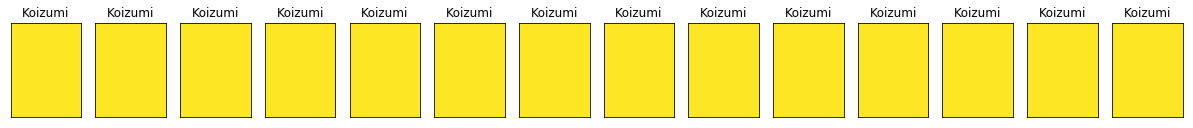

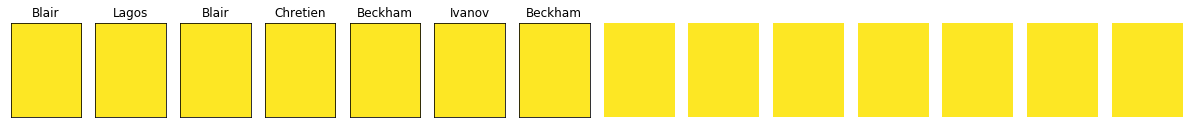

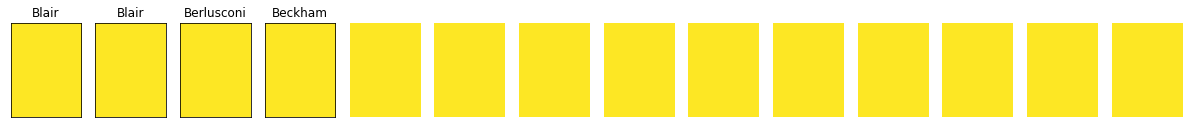

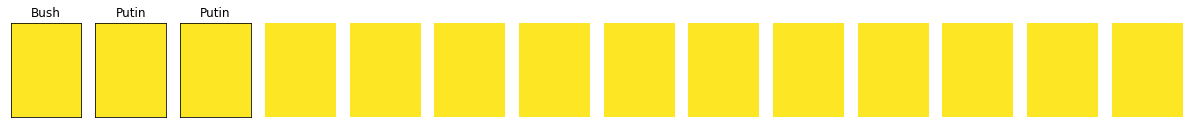

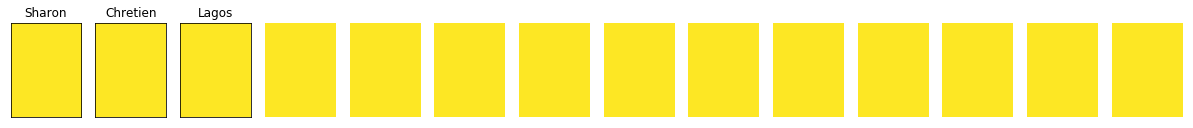

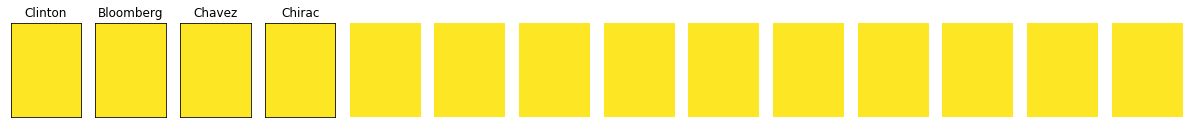

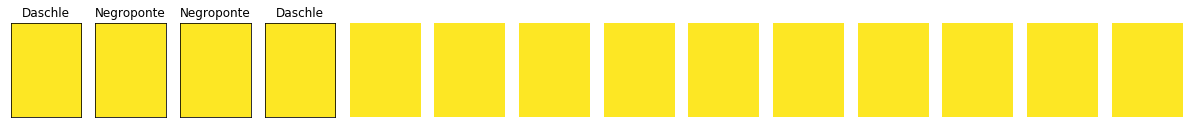

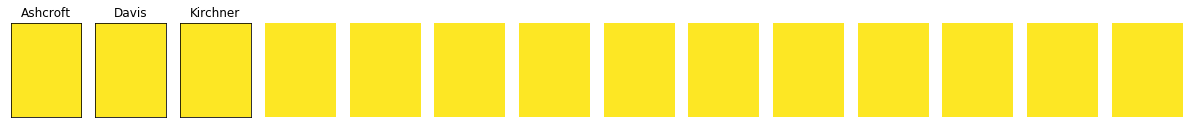

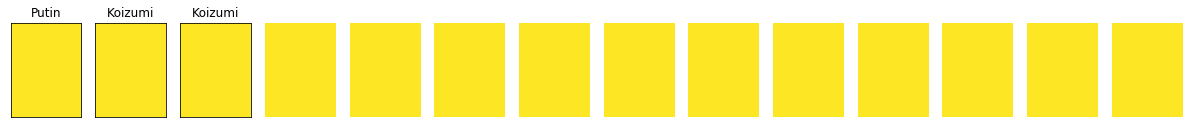

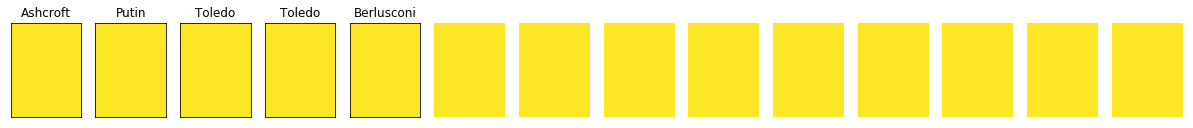

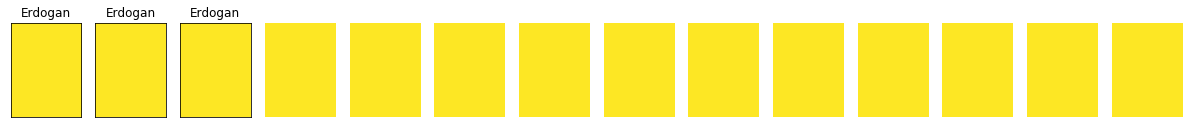

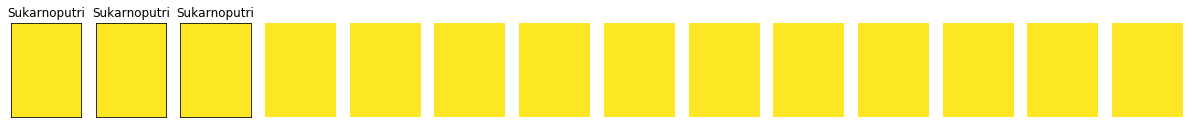

In [13]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, 14, figsize=(14*1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    i = 0
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
        i += 1
    for j in range(len(axes) - i):
        axes[j+i].imshow(np.array([[1]*65]*87), vmin=0, vmax=1)
        axes[j+i].axis('off')

- DBSCAN의 단점
  - 클러스터의 개수 컨트롤을 직접적으로 할 수 없음
  - 사이즈가 큰 하나의 클러스터가 항상 생성되고 있음

##### Analyzing the faces dataset with agglomerative clustering

In [14]:
n_clusters = 10
# k-평균으로 클러스터를 추출합니다
km = KMeans(n_clusters=n_clusters, random_state=0)
labels_km = km.fit_predict(X_pca)
print("k-평균의 클러스터 크기: {}".format(np.bincount(labels_km)))

k-평균의 클러스터 크기: [155 175 238  75 358 257  91 219 323 172]


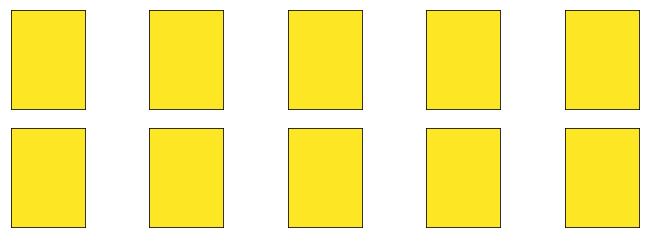

In [15]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
              vmin=0, vmax=1)

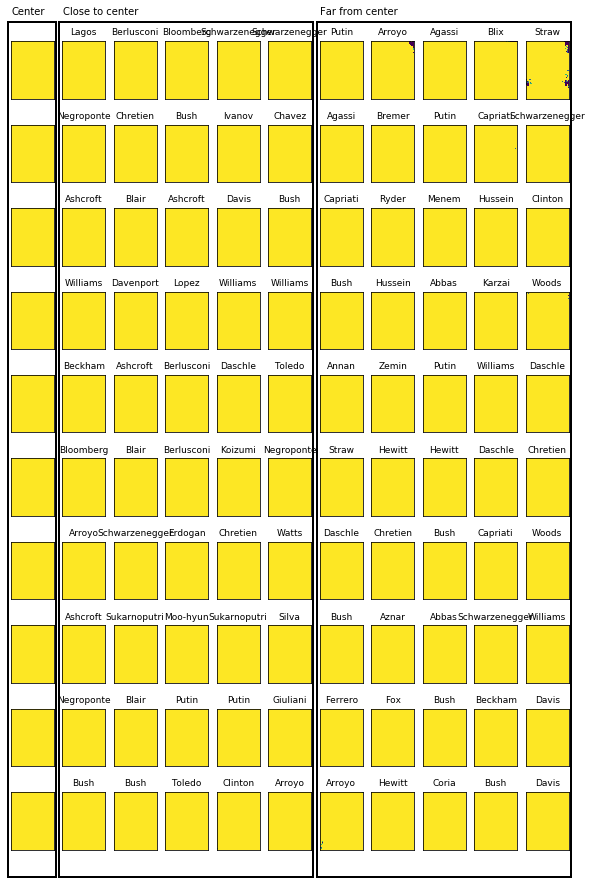

In [16]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people,
                                y_people, people.target_names)

In [17]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]


- k-means 클러스터링 결과와 AgglomerativeClustering 클러스터링 결과를 ARI 도구를 활용하여 비교 평가하기 
  - 결과값: 0.13 - 공통 부분이 거의 없다고 볼 수 있음

In [18]:
print("ARI: {:.2f}".format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.09


- Dendrogram 그리기 
  - 트리 깊이 제한
    - p=7, truncate_mode='level'
      - 최대 level을 7로 제한

Text(0,0.5,'Cluster distance')

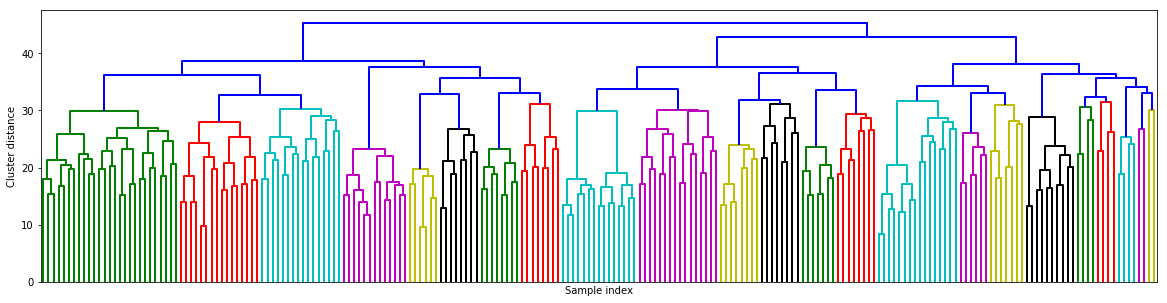

In [19]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(X_pca)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

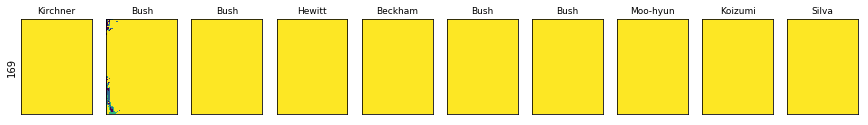

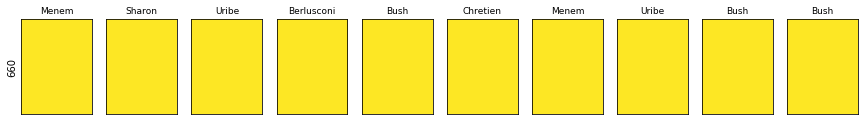

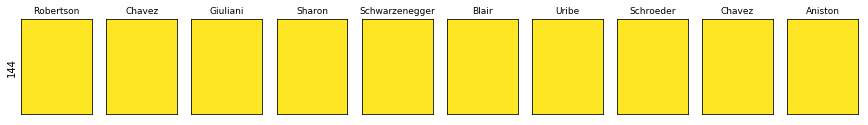

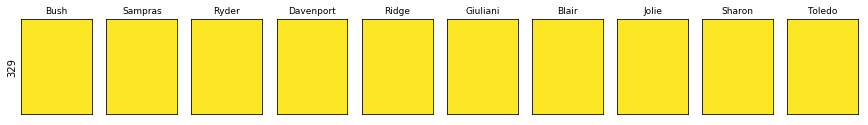

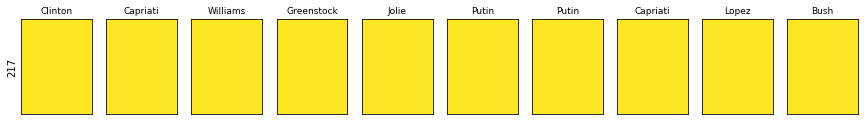

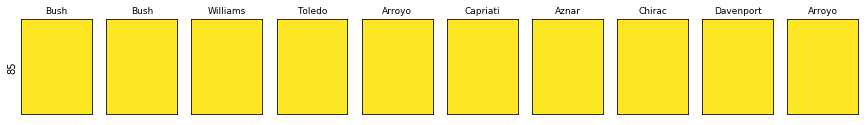

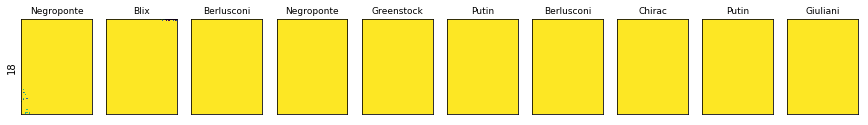

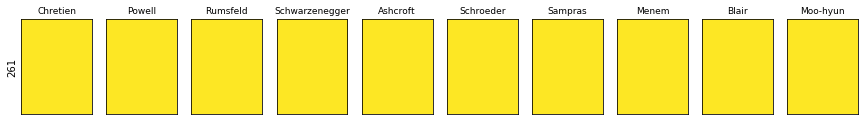

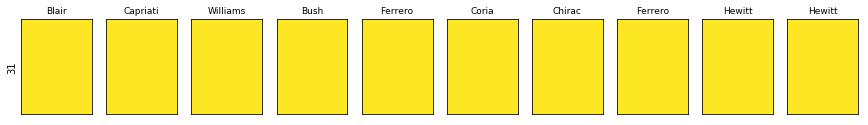

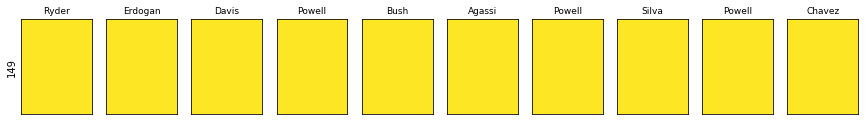

In [20]:
n_clusters = 10

for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})

cluster sizes agglomerative clustering: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


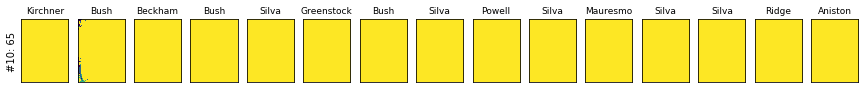

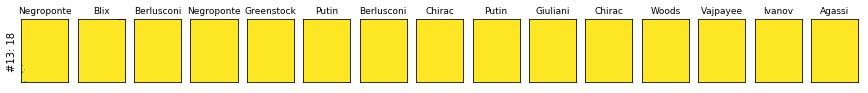

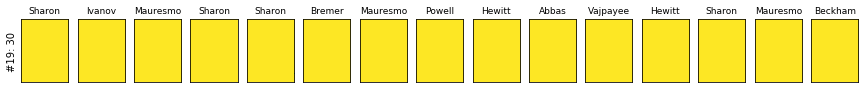

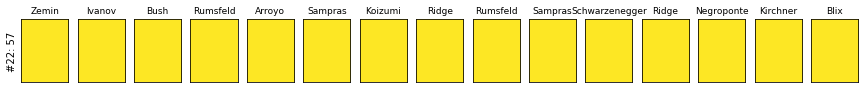

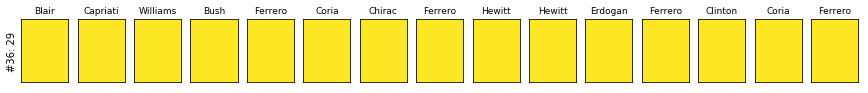

In [21]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))

    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})

    for i in range(cluster_size, 15):
        axes[i].set_visible(False)

In [22]:
## 이미지 보이게 다시 해볼것...